## Introduction to the dataset
The Bank Account Fraud (BAF) suite of datasets, recently published at NeurIPS 2022, offers a comprehensive collection of synthetic bank account fraud tabular datasets.This suite comprises six distinct datasets, making it a valuable resource for evaluating both novel and existing machine learning (ML) and fair ML methods in the field of fraud detection.  

One notable aspect of the BAF datasets is their realism. They are constructed based on present-day real-world datasets specifically curated for fraud detection purposes. This ensures that the datasets closely resemble actual fraud scenarios encountered in financial transactions, making them highly relevant for developing and testing fraud detection models. 

The BAF datasets introduce controlled bias and imbalanced class distributions, making it valuable for developing fair ML techniques and addressing class imbalance in fraud detection. They are dynamic, featuring temporal data and distribution shifts. Privacy is ensured through privacy-preserving techniques such as differential privacy and generative modeling.  

Overall, the Bank Account Fraud (BAF) suite of datasets represents a significant contribution to the field of fraud detection. With their realistic, biased, imbalanced, dynamic, and privacy-preserving nature, these datasets serve as an invaluable resource for evaluating and advancing ML and fair ML methods in the domain of fraud detection.  

You can find the dataset [here](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022).

## Problem statement
The problem is to develop a machine learning model that can effectively detect fraudulent bank account activities using the Bank Account Fraud (BAF) suite of datasets. The goal is to build a robust and accurate fraud detection system that can identify fraudulent transactions while minimizing false positives.

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import matplotlib.pyplot as plt

## Data collection

### Reading the dowloaded .csv

In [2]:
transactions = pd.read_csv('data/Base.csv')

### Checking for null values

In [3]:
transactions.isna().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

Fortunately for us, the data seems to be clean.

## Data cleaning and preprocessing

### Label encoding
We are going to use **LabelEncoder** from the sklearn library. We have identified 4 variables that need label encoding as per the data description.
They are : 
- payment_type_encoded(categorical) - Credit payment plan type. 5 possible (annonymized) values.
- employment_status (categorical): Employment status of the applicant. 7 possible (annonymized) values.
- housing_status (categorical): Current residential status for applicant. 7 possible (annonymized) values.
- device_os (categorical): Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.

In [4]:
label_encoder = LabelEncoder()
transactions['payment_type_encoded'] = label_encoder.fit_transform(transactions['payment_type'])
transactions['employment_status_encoded'] = label_encoder.fit_transform(transactions['employment_status'])
transactions['housing_status_encoded'] = label_encoder.fit_transform(transactions['housing_status'])
transactions['device_os_encoded'] = label_encoder.fit_transform(transactions['device_os'])

### One-hot encoding
In the dataset there is one binary categorical variable which is : 
- source (categorical): Online source of application. Either browser (INTERNEI) or app (TELEAPP).

Due to it being binary we can use **.get_dummies** from pandas to encode this variable.

In [5]:
source_encoded = pd.get_dummies(transactions['source'], prefix='source')
transactions_encoded = pd.concat([transactions, source_encoded], axis=1)

Now let's drop all the non-encoded variables from the transactions_encoded dataframe.

In [6]:
transactions_encoded = transactions_encoded.drop(['source', 'payment_type', 'employment_status', 'housing_status', 'device_os'], axis=1)

### Feature engineering
There are two features we can engineer from the current dataset that could give us some more information that could be important to the future model.  
- address_stablity  

We can combine the information from "prev_address_months_count" and "current_address_months_count" to create a feature that represents the stability of the applicant's address. We can take the difference of the two to form our applicant's address stability.

- application velocity  

We can combine the velocity variables ("velocity_6h," "velocity_24h," "velocity_4w") to create an aggregated velocity feature. We can take the average of these variables to represent the overall application velocity of the applicant.

In [7]:
transactions_encoded['address_stability'] = transactions_encoded['current_address_months_count'] - transactions_encoded['prev_address_months_count']
transactions_encoded['application_velocity'] = (transactions_encoded['velocity_6h'] + transactions_encoded['velocity_24h'] + transactions_encoded['velocity_4w']) / 3

## Explanatory data analysis

### Class imbalance
It is improtant to check just how severe our class imbalance is for our target variable - fraud_bool.

In [8]:
fraud_counts = transactions_encoded['fraud_bool'].value_counts()

percentage_fraud_1 = (fraud_counts[1] / len(transactions_encoded)) * 100
percentage_fraud_0 = (fraud_counts[0] / len(transactions_encoded)) * 100

print("Percentage of fraud_bool = 1:", percentage_fraud_1)
print("Percentage of fraud_bool = 0:", percentage_fraud_0)

Percentage of fraud_bool = 1: 1.1029
Percentage of fraud_bool = 0: 98.89710000000001


Class imbalance poses a major obstacle in fraud detection models, as it introduces a significant disparity in the number of instances between the positive class (indicating fraud) and the negative class (representing legitimate transactions).   
This skewed distribution of data makes it difficult for the model to effectively learn and classify rare instances of fraud accurately.

### Correlations to the target variable
Let's check on the correlations with fraud_bool.

In [9]:
independent_vars = [col for col in transactions_encoded.columns if col != 'fraud_bool']
X = transactions_encoded[independent_vars]
y = transactions_encoded['fraud_bool']

In [10]:
correlations = X.corrwith(y)

sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

credit_risk_score                   0.070624
proposed_credit_limit               0.068907
customer_age                        0.062959
device_os_encoded                   0.057834
income                              0.045079
address_stability                   0.037867
device_distinct_emails_8w           0.035704
current_address_months_count        0.033701
payment_type_encoded                0.028304
email_is_free                       0.027758
foreign_request                     0.016885
month                               0.013250
session_length_in_minutes           0.008999
zip_count_4w                        0.005212
source_TELEAPP                      0.003922
days_since_request                  0.000567
bank_months_count                  -0.003222
source_INTERNET                    -0.003922
velocity_24h                       -0.011183
velocity_4w                        -0.011536
bank_branch_count_8w               -0.011577
phone_mobile_valid                 -0.013180
velocity_6

The correlations between the independent variables and the target variable (fraud_bool) appear to be relatively low. This could be attributed to the imbalance in the distribution of the target variable, which can make the task of detecting fraud more challenging.

Among the variables with positive correlations, we observe that credit_risk_score, proposed_credit_limit, and income show relatively stronger associations with fraud. This suggests that individuals with higher credit risk scores, larger proposed credit limits, and higher incomes may have a slightly higher likelihood of engaging in fraudulent activities.

## Feature selection
Our feature selection process will be defined by using **VarianceThreshold** from the sklearn library. The threshold we are going to set is 0.1.

In [11]:
threshold = 0.1
variance_selector = VarianceThreshold(threshold=threshold)
variance_selector.fit(transactions_encoded)
selected_features_mask = variance_selector.get_support()
selected_features = transactions_encoded.columns[selected_features_mask]
X_selected = transactions_encoded[selected_features]
unselected_features = transactions_encoded.columns[~selected_features_mask]

Let's see the features that didn't make the cut.

In [12]:
unselected_features

Index(['fraud_bool', 'income', 'name_email_similarity', 'phone_mobile_valid',
       'foreign_request', 'device_distinct_emails_8w', 'device_fraud_count',
       'source_INTERNET', 'source_TELEAPP'],
      dtype='object')

Let's remove them from our data.

In [13]:
X = transactions_encoded.drop(['fraud_bool', 'device_fraud_count', 'income', 'name_email_similarity', 'phone_mobile_valid',
                               'foreign_request', 'device_distinct_emails_8w', 'source_INTERNET', 'source_TELEAPP'], axis=1)
y = transactions_encoded['fraud_bool']

## Handling class imbalance
To handle the class imbalance demostrated earlier, we are going to use **RandomOverSampler** from the imblearn library.  
Oversampling involves increasing the number of instances in the minority class by generating synthetic samples, thus balancing the distribution of the classes. This helps to alleviate the bias and allows the model to learn from a more representative dataset.This can potentially improve the model's ability to learn the patterns and characteristics associated with fraud, leading to better predictions and fraud detection performance.

In [14]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_selected, y)

## Train test split and scaling
Now that we have handled class imbalance, it's time to split the dataset into training and testing data.
We are going to use **train_test_split** from the sklearn library to do that.  
Stratify is also being used to ensure that the class distribution in the original dataset is maintained in both the training and testing subsets. By doing that, the split will contain a proportional representation of both fraud and non-fraud cases, preserving the imbalance solution achieved through oversampling.  
The use of stratify is particularly important in cases of class imbalance, as it helps prevent situations where one subset ends up with significantly fewer instances of the minority class, which could negatively impact model training and evaluation. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

Another step we are going to take is scaling our features.  
We are going to use **StandardScaler** from the sklearn library.  
Scaling is used to ensure that all the features have similar scales and distributions. This is important because many machine learning algorithms are sensitive to the scale of the input features.
In our model, scaling is particularly important because it can help prevent certain features from dominating the learning process due to their larger scales - like fraud_bool. It ensures that all features contribute proportionately to the model training, which is essential for capturing patterns and making accurate predictions.

We are only scaling X because scaling y could potentially introduce unwanted biases or affect the interpretability of the results.

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model training
The model we have picked for fraud detection is XGBoost. Some of the reasons are as follows:
- High performance: it is efficient and can handle large-scale datasets, making it suitable for processing a significant amount of data in fraud detection tasks.

- Gradient boosting: it is an ensemble learning algorithm that combines weak models (decision trees) iteratively. By learning from previous models' mistakes, XGBoost focuses on difficult-to-predict instances, which is crucial for detecting complex fraud patterns.

- Feature importance: it allows evaluation of feature importance, helping identify influential features in fraud detection. This guides feature engineering efforts and provides insights into fraudulent transaction characteristics

We have also set use_label_encoder to False since we are getting a warning when fitting the data.

In [17]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, random_state=42)

In [18]:
xgb_classifier.fit(X_train_scaled, y_train)

[15:16:33] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Training the model is time consuming since our data consists of 800,000 records.

### Feature importance
Let's see our feature importance provided handily from our XGBoost model.

In [19]:
importance_scores = xgb_classifier.feature_importances_

Let's create a dataframe so we can visualise it better.

In [20]:
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names[:len(importance_scores)], 'Importance': importance_scores})

sorted_feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

sorted_feature_importance_df

,Feature,Importance
0,housing_status_encoded,0.193356
1,device_os_encoded,0.107643
2,phone_home_valid,0.095807
3,has_other_cards,0.080119
4,keep_alive_session,0.076785
5,prev_address_months_count,0.056437
6,email_is_free,0.051698
7,customer_age,0.033233
8,employment_status_encoded,0.030284
9,proposed_credit_limit,0.030024


We can make some key observations regarding feature importance.
- Housing status: The housing status of a person appears to be the most influential feature. It suggests that people with certain types of housing arrangements may be more prone to engaging in fraudulent activities. For example, people living in temporary accommodations or unstable housing situations might exhibit higher fraud risk.

- Device OS: The type of device operating system used during the transaction or application process is another important factor. Fraudsters may exploit specific device vulnerabilities or utilize certain OS features to carry out fraudulent activities. By considering the device OS, the fraud detection model can identify patterns and flag suspicious transactions.

- Phone validity: The validity of the phone number associated with the home address is an essential feature. Fraudsters may provide fake or invalid phone numbers, making it difficult to establish contact or verify customer details. A higher importance score for this feature suggests that fraudsters often manipulate or provide false phone numbers to carry out fraudulent activities.

- Other cards: The presence of other credit or payment cards owned by the customer is a relevant feature. Individuals with multiple cards may have a higher risk of involvement in fraudulent transactions. Fraudsters often acquire multiple cards to carry out coordinated frauds or engage in unauthorized transactions.

- Session longevity: Maintaining a continuous session during the application process is an important indicator of potential fraud. Fraudsters may create disruptions or abruptly end sessions to avoid detection or manipulate the application process. By emphasizing the importance of session continuity, the model can flag such suspicious activities.

### Predicting fraud on unseen data

In [21]:
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

## Model evaluation

### Classification report
**Classification_report** from sklearn is used to evaluate the performance of a classification model in binary classification tasks. It provides metrics such as precision, recall, F1-score, and support. These metrics help assess the model's ability to accurately predict positive instances (fraud cases) and minimize false positives and false negatives. By using the classification report, we can measure the model's performance and make informed decisions regarding its deployment for fraud detection.

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88    197795
           1       0.87      0.91      0.89    197794

    accuracy                           0.89    395589
   macro avg       0.89      0.89      0.89    395589
weighted avg       0.89      0.89      0.89    395589



Let's summarise what we can observe from the report.

- Precision: The precision for class 0 (non-fraud cases) is 0.91, indicating that out of all the instances predicted as non-fraud, 91% are actually non-fraud. The precision for class 1 (fraud cases) is 0.87, meaning that out of all the instances predicted as fraud, 87% are actually fraud.

- Recall: The recall for class 0 is 0.86, indicating that the model correctly identifies 86% of the actual non-fraud cases. The recall for class 1 is 0.91, meaning that the model captures 91% of the actual fraud cases.

- F1-score: For class 0, the F1-score is 0.88, and for class 1, it is 0.89. These scores provide a balanced measure of the model's performance, considering both precision and recall.

- Support: The support represents the number of instances of each class in the test set. In this case, there are 197,795 instances of class 0 and 197,794 instances of class 1.

- Accuracy: The overall accuracy of the model is 0.89, indicating that it correctly classifies 89% of the instances in the test set.

## Precision-Recall curve
We use the  precision-recall curve to evaluate a binary classification model's performance in cases of imbalanced classes. It shows the trade-off between precision and recall at different probability thresholds, helping us assess the model's ability to identify positive cases (fraud) accurately. It provides a visual representation of performance and is useful when accuracy alone is not reliable due to class imbalance.  
We use the appropriate functions from sklearn.

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

Now that we have calculated the number, let's plot it.

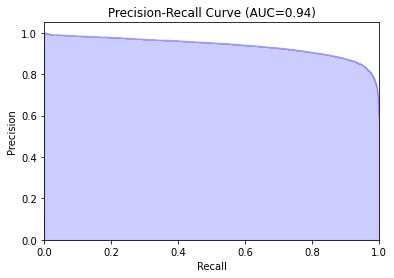

In [24]:
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AUC={:.2f})'.format(pr_auc))
plt.show()

We see that we get a value of 0.94. The area under the curve (AUC) represents the model's ability to distinguish between positive and negative classes, with a value ranging from 0 to 1.  
A value of 0.94 indicates that the model is capable of differentiating between fraud and non-fraud transactions with a high degree of accuracy.

## Receiver Operating Characteristic (ROC) curve
We use ROC to evaluate the performance of our model. It provides a visual representation of the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) across different classification thresholds. By plotting the ROC curve, we can assess how well the model can distinguish between positive and negative classes. The curve's shape and the area under it (AUC again) indicate the model's overall performance, with a higher AUC suggesting better ability.  
Again, we use the appropriate sklearn functions to calculate the curve.

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

And now let's visualise it.

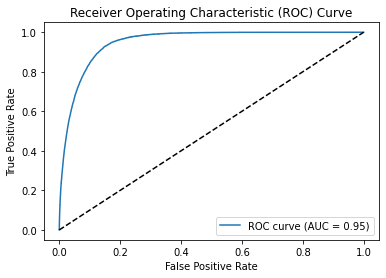

In [26]:
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

AUC is 0.95, it indicates that our model has a high true positive rate and a low false positive rate.

The "lasso" shape of the ROC curve suggests that the model is performing well across a range of decision thresholds. It implies that the model achieves high true positive rates while maintaining a relatively low false positive rate. This is a desirable property for our fraud detection model since it indicates that the model can effectively identify fraudulent transactions without generating a large number of false positives.

The AUC value of 0.95 further confirms the model's strong discriminatory power. An AUC close to 1 indicates that the model has a high probability of ranking a randomly chosen fraudulent transaction higher than a randomly chosen non-fraudulent transaction.